# MCNN (Multi-Column Convolutional Neural Network) for Crowd Counting

In [9]:
!pip install opencv-python matplotlib --quiet

import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ==============================
# Synthetic Dataset for Crowd Counting
# ==============================


In [10]:
class SyntheticCrowdDataset(Dataset):
    def __init__(self, num_samples=100, image_size=(128, 128), max_people=30):
        self.num_samples = num_samples
        self.image_size = image_size
        self.max_people = max_people

    def generate_image_and_density(self):
        image = np.zeros(self.image_size, dtype=np.float32)
        density_map = np.zeros(self.image_size, dtype=np.float32)
        num_people = random.randint(1, self.max_people)

        for _ in range(num_people):
            x = random.randint(0, self.image_size[0] - 1)
            y = random.randint(0, self.image_size[1] - 1)
            image[x, y] = 1.0
            density_map[x, y] = 1.0

        density_map = gaussian_filter(density_map, sigma=3)
        return image, density_map

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, density = self.generate_image_and_density()
        image = np.expand_dims(image, axis=0)
        density = np.expand_dims(density, axis=0)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(density, dtype=torch.float32)

train_dataset = SyntheticCrowdDataset(num_samples=200)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


# ==============================
# MCNN Model Definition
# ==============================

In [11]:
class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()

        def column(in_channels, filters):
            return nn.Sequential(
                nn.Conv2d(in_channels, filters[0], 9, padding=4),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(filters[0], filters[1], 7, padding=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(filters[1], filters[2], 7, padding=3),
                nn.ReLU(inplace=True),
                nn.Conv2d(filters[2], filters[3], 7, padding=3),
                nn.ReLU(inplace=True)
            )

        self.branch1 = column(1, [16, 32, 16, 8])     # large receptive field
        self.branch2 = column(1, [20, 40, 20, 10])    # medium
        self.branch3 = column(1, [24, 48, 24, 12])    # small

        self.output_layer = nn.Sequential(
            nn.Conv2d(30, 1, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat((x1, x2, x3), dim=1)
        out = self.output_layer(x_cat)
        return out


# ==============================
# Training the MCNN
# ==============================

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for images, densities in train_loader:
        images, densities = images.to(device), densities.to(device)
        outputs = model(images)

        # Fix: Downsample ground truth to match output size
        densities = F.interpolate(densities, size=outputs.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, densities)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[MCNN] Epoch {epoch+1}, Loss: {total_loss:.4f}")



[MCNN] Epoch 1, Loss: 0.0341
[MCNN] Epoch 2, Loss: 0.0002
[MCNN] Epoch 3, Loss: 0.0003
[MCNN] Epoch 4, Loss: 0.0002
[MCNN] Epoch 5, Loss: 0.0002
[MCNN] Epoch 6, Loss: 0.0002
[MCNN] Epoch 7, Loss: 0.0003
[MCNN] Epoch 8, Loss: 0.0002
[MCNN] Epoch 9, Loss: 0.0002
[MCNN] Epoch 10, Loss: 0.0002


# ==============================
# Evaluation and Visualization
# ==============================

GT Count: 22.00, Predicted Count: 0.00


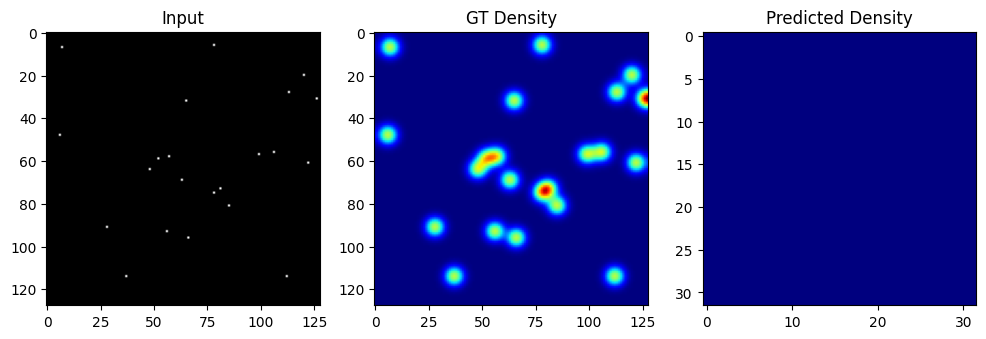

In [13]:
model.eval()
with torch.no_grad():
    sample_img, sample_gt = train_dataset[0]
    sample_img = sample_img.unsqueeze(0).to(device)
    pred = model(sample_img).squeeze().cpu().numpy()
    gt = sample_gt.squeeze().numpy()

    print(f"GT Count: {gt.sum():.2f}, Predicted Count: {pred.sum():.2f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img.squeeze().cpu(), cmap='gray')
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='jet')
    plt.title("GT Density")
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='jet')
    plt.title("Predicted Density")
    plt.show()
